# Step 1: remove the flight effects from the sensors

In [11]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = os.path.dirname(os.getcwd())
print(base_dir)
sys.path.insert(1, base_dir)
from package.api import DB as api
import package.utils as utils

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers, metrics
import tensorflow_addons as tfa

import keras_tuner as kt

from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)


%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/oem/phm2021_data_challenge
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# THESE ARE YOUR CREDENTIALS IN PLAIN TEXT!
params = utils.get_aws_secret("/secret/cmapss")
#print(params)
db, cur =  api.connect(params)
db.set_session(autocommit=True)
del(params)

[INFO] connecting to db.
[INFO] connected.


### use all units, downsample by a factor of 10

In [33]:
units = api._get_units(db=db)
units[0:10]

,id,serial_number,age,eol,rul,group_id,Fc,unit,dataset
0,1,HD3QgeG7,0.0,100.0,100.0,1,1,1,DS01-005
1,2,BUcOUKMQ,0.0,75.0,75.0,1,3,2,DS01-005
2,3,6n1MJJrg,0.0,100.0,100.0,1,2,3,DS01-005
3,4,3Ewe04EX,0.0,95.0,95.0,1,1,4,DS01-005
4,5,RXPSDX5O,0.0,89.0,89.0,1,3,5,DS01-005
5,6,oKlALxDg,0.0,94.0,94.0,1,2,6,DS01-005
6,7,7dRr8CZy,0.0,90.0,90.0,2,1,7,DS01-005
7,8,SMLGbntz,0.0,89.0,89.0,2,2,8,DS01-005
8,9,M2YaAZVX,0.0,80.0,80.0,2,1,9,DS01-005
9,10,qnkiQU4v,0.0,82.0,82.0,2,3,10,DS01-005


In [4]:
df = api._get_data(db=db, units=list(np.arange(1,len(units)+1)), tables=['summary_tb', 'telemetry_tb'], downsample=10).astype(np.float32)
df['time'] = ""
df

,cycle,hs,alt,Mach,TRA,T2,Fc,id,asset_id,Wf,...,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,time
0,1.0,1.0,3081.0,0.37945,70.399887,522.302124,1.0,10.0,1.0,4.61854,...,1849.662109,1268.917725,19.417179,14.47169,19.712879,24.398430,394.431732,400.930573,15.94352,
1,1.0,1.0,3153.0,0.38449,70.575668,522.428162,1.0,20.0,1.0,4.62365,...,1850.533203,1268.849243,19.423830,14.47184,19.719620,24.418449,394.727753,401.229858,15.91869,
2,1.0,1.0,3229.0,0.39079,70.575668,522.645020,1.0,30.0,1.0,4.62018,...,1850.241699,1268.180908,19.430220,14.48017,19.726110,24.431101,394.555176,401.060028,15.88700,
3,1.0,1.0,3305.0,0.39438,70.575668,522.651184,1.0,40.0,1.0,4.61099,...,1849.517334,1267.364746,19.410761,14.46770,19.706360,24.409960,393.944061,400.443970,15.84730,
4,1.0,1.0,3393.0,0.39690,70.663559,522.530090,1.0,50.0,1.0,4.60386,...,1849.327271,1266.863159,19.377689,14.44066,19.672779,24.374081,393.353241,399.842834,15.80476,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338306,54.0,0.0,3151.0,0.21622,40.341511,512.176086,2.0,63383072.0,90.0,2.78053,...,1615.113647,1182.692139,16.533640,13.49090,16.785419,19.519159,269.957642,274.905396,14.54540,
6338307,54.0,0.0,3110.0,0.21559,40.341511,512.295837,2.0,63383080.0,90.0,2.78551,...,1615.702026,1183.192993,16.555651,13.50874,16.807770,19.544340,270.338898,275.291595,14.56780,
6338308,54.0,0.0,3072.0,0.21678,40.341511,512.486755,2.0,63383088.0,90.0,2.79070,...,1616.227417,1183.559570,16.584089,13.53273,16.836639,19.578011,270.775238,275.736084,14.58902,
6338309,54.0,0.0,3035.0,0.21609,40.341511,512.588135,2.0,63383100.0,90.0,2.79368,...,1616.365601,1183.671875,16.604031,13.54828,16.856890,19.602449,271.099579,276.068298,14.60775,


### add a positional variable to give the time within a cycle

In [5]:
for unit in pd.unique(units.id):
    for cycle in pd.unique(df[df.asset_id == unit].cycle):
        length = len(df[(df.asset_id == unit) & (df.cycle == cycle)])
        x = np.arange(0, length)/(length-1)
        df.loc[(df.asset_id == unit) & (df.cycle == cycle), 'time'] = x

### train on only hs == 1
- this may or may not be necessary, but we have the information

In [6]:
df1 = df[(df.hs == 1)]

,cycle,hs,alt,Mach,TRA,T2,Fc,id,asset_id,Wf,...,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,time
0,1.0,1.0,3081.0,0.37945,70.399887,522.302124,1.0,10.0,1.0,4.61854,...,1849.662109,1268.917725,19.417179,14.47169,19.712879,24.398430,394.431732,400.930573,15.94352,0.0
1,1.0,1.0,3153.0,0.38449,70.575668,522.428162,1.0,20.0,1.0,4.62365,...,1850.533203,1268.849243,19.423830,14.47184,19.719620,24.418449,394.727753,401.229858,15.91869,0.002232
2,1.0,1.0,3229.0,0.39079,70.575668,522.645020,1.0,30.0,1.0,4.62018,...,1850.241699,1268.180908,19.430220,14.48017,19.726110,24.431101,394.555176,401.060028,15.88700,0.004464
3,1.0,1.0,3305.0,0.39438,70.575668,522.651184,1.0,40.0,1.0,4.61099,...,1849.517334,1267.364746,19.410761,14.46770,19.706360,24.409960,393.944061,400.443970,15.84730,0.006696
4,1.0,1.0,3393.0,0.39690,70.663559,522.530090,1.0,50.0,1.0,4.60386,...,1849.327271,1266.863159,19.377689,14.44066,19.672779,24.374081,393.353241,399.842834,15.80476,0.008929


In [ ]:
# utils.plot_feature_distributions(df=df1, feature_range=(-1,1), figsize=(12,4))

In [ ]:
# sns.pairplot(df1, diag_kind='kde')

### split into train, test, val sets

In [ ]:
#print(df1.columns)

In [34]:
X_cols = ['Mach', 'alt', 'TRA', 'T2', 'time']#, 'Fc'] # will also have Fc_1, Fc_2, Fc_3
y_cols = ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50']

X = df1[X_cols]
# X = pd.concat([df1[X_cols], pd.get_dummies(df1['Fc']).rename(columns = lambda x: 'Fc_' + str(int(x)))], axis=1)
y = df1[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=14, shuffle=True)

### normalize data

In [35]:
feature_range = (0,1)

xscaler = MinMaxScaler(feature_range=feature_range)
X_train_scaled = xscaler.fit_transform(X_train)
X_val_scaled = xscaler.transform(X_val)
X_test_scaled = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=feature_range)
y_train_scaled = yscaler.fit_transform(y_train)
y_val_scaled = yscaler.transform(y_val)
y_test_scaled = yscaler.transform(y_test)

### get a sample for after training testing

T30


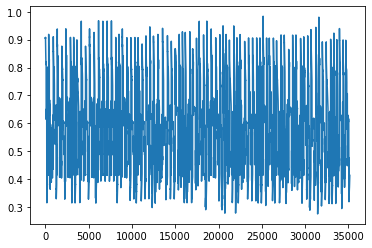

In [36]:
idx = 4
asset_id = 9
print(y_cols[idx])

y_full = df[df.asset_id == asset_id][y_cols]
X_full = df[df.asset_id == asset_id][X_cols]
#X_full = pd.concat([df[X_cols], pd.get_dummies(df['Fc']).rename(columns = lambda x: 'Fc_' + str(int(x)))], axis=1)

trace = yscaler.transform(y_full)[:,idx]

plt.plot(trace)
plt.show()


## build, compile, train, plot results

In [37]:
input_shape = (len(X_train.keys()),)
output_shape = len(y_train.keys())
print(input_shape)
print(output_shape)

(5,)
14


Epoch 1/200
2848/2848 [==============================] - 6s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 1.2642e-05 - val_root_mean_squared_error: 0.0036 - lr: 0.0010
Epoch 2/200
2848/2848 [==============================] - 6s 2ms/step - loss: 1.0618e-05 - root_mean_squared_error: 0.0033 - val_loss: 5.1482e-06 - val_root_mean_squared_error: 0.0023 - lr: 0.0010
Epoch 3/200
2848/2848 [==============================] - 6s 2ms/step - loss: 8.7204e-06 - root_mean_squared_error: 0.0030 - val_loss: 1.5613e-05 - val_root_mean_squared_error: 0.0040 - lr: 9.5000e-04
Epoch 4/200
2848/2848 [==============================] - 6s 2ms/step - loss: 7.3691e-06 - root_mean_squared_error: 0.0027 - val_loss: 3.4084e-06 - val_root_mean_squared_error: 0.0018 - lr: 9.0250e-04
Epoch 5/200
2848/2848 [==============================] - 6s 2ms/step - loss: 6.3682e-06 - root_mean_squared_error: 0.0025 - val_loss: 1.3442e-05 - val_root_mean_squared_error: 0.0037 - lr: 8.5737e-04
Epoch 6/200


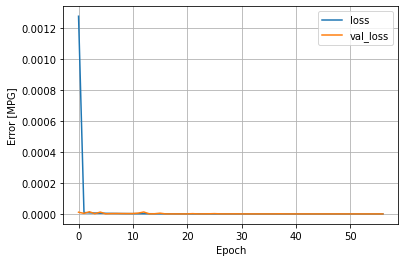

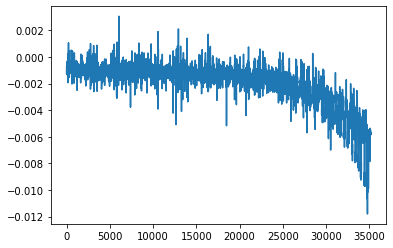

In [45]:
batch_size = 512
epochs = 200

monitor = 'val_root_mean_squared_error'
mode = 'min'
min_delta = .0001
patience = 40

inputs = keras.Input(shape=input_shape, name='in1')
x = layers.Dense(units=56, activation='relu', name='hd1')(inputs)
x = layers.Dense(units=112, activation='relu', name='hd2')(x)
x = layers.Dense(units=112, activation='relu', name='hd3')(x)
x = layers.Dense(units=112, activation='relu', name='hd4')(x)
x = layers.Dense(units=56, activation='relu', name='hd5')(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs=inputs, outputs=outputs)


# lr_scheduler = optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=.0005,
#     decay_steps=int(len(X_train)/batch_size),
#     decay_rate=.999,
#     staircase=True)

# model.compile(optimizer=optimizers.Adam(learning_rate=lr_scheduler), loss='mse', metrics=[metrics.RootMeanSquaredError()])

model.compile(optimizer=optimizers.Adam(learning_rate=.001), loss='mse', metrics=[metrics.RootMeanSquaredError()])

def decay_schedule(epoch, lr):
    if epoch > 1:
        lr = lr * .95
    return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(decay_schedule)

early_stopping = keras.callbacks.EarlyStopping(monitor=monitor,
                                               mode=mode,
                                               min_delta=min_delta,
                                               patience=patience,
                                               verbose=1,
                                               restore_best_weights=False)#True)

history = model.fit(X_train_scaled,
                    y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_scaled, y_val_scaled),
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

utils.plot_loss(history)

pred = model.predict(xscaler.transform(X_full))[:,idx]
res = trace - pred

plt.plot(res)
plt.show()

In [47]:
save_dir = 'models/ncmapss/'
name = 'flight_effects'

model.save(save_dir + name + '.h5')
model.save(save_dir + name)

with open(save_dir + name + '_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

2022-01-28 16:46:01.172126: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/ncmapss/flight_effects/assets
